In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmlstm_network import HMLSTMNetwork
import tensorflow as tf
from text_input_utils import prepare_inputs
import tensorflow as tf
from string import ascii_lowercase

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Regression example

In [2]:
# simulate multiresolution data
num_signals = 1000
signal_length = 40 * 2
x = np.linspace(0, 40 * np.pi, signal_length)
signals = [np.random.normal(0, 1, size=signal_length) 
           + (5 * np.sin(1 * x + np.random.random() * 100 * np.pi))
           + (5 * np.sin(.2 * x + np.random.random() * 100 * np.pi))
          for _ in range(num_signals)]

split = int(num_signals * .8)
train = signals[:split]
test = signals[split:]

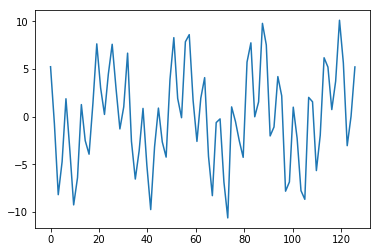

In [3]:
# example signal
plt.plot(x, signals[2]);

In [4]:
# prepare data
train_batches_in = []
train_batches_out = []
batch_size = 2
start = 0
while start + batch_size < len(train):
    batch = train[start: start + batch_size]
    
    train_batches_in.append(np.array([s[:-1] for s in batch]).reshape(batch_size, -1, 1))
    train_batches_out.append(np.array([s[1:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size
    
    
batch_size = 1
start = 0
test_batches_in = []
test_batches_out = []
while start + batch_size < len(test):
    batch = test[start: start + batch_size]
    
    test_batches_in.append(np.array([s[:-1] for s in batch]).reshape(batch_size, -1, 1))
    test_batches_out.append(np.array([s[1:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size

In [5]:
tf.reset_default_graph()
network = HMLSTMNetwork(input_size=1, task='regression', hidden_state_sizes=100,
                       embed_size=200, out_hidden_size=100, num_layers=2)

In [6]:
network.train(train_batches_in, train_batches_out, load_existing_vars=False)

Epoch 0
loss: 1784.01
loss: 1694.31
loss: 1706.02
loss: 1656.44
loss: 1581.61
loss: 1694.79
loss: 1679.48
loss: 1681.24
loss: 1554.04
loss: 1564.64
loss: 1507.76
loss: 1557.24
loss: 1518.03
loss: 1532.76
loss: 1388.8
loss: 1513.99
loss: 1443.56
loss: 1439.25
loss: 1512.88
loss: 1413.64
loss: 1336.91
loss: 1393.69
loss: 1278.85
loss: 1317.27
loss: 1270.6
loss: 1309.09
loss: 1299.66
loss: 1125.58
loss: 1160.25
loss: 1108.74
loss: 985.291
loss: 952.811
loss: 1016.31
loss: 913.383
loss: 860.636
loss: 688.394
loss: 767.599
loss: 994.477
loss: 586.64
loss: 570.636
loss: 588.886
loss: 516.462
loss: 580.029
loss: 434.265
loss: 483.299
loss: 480.558
loss: 561.061
loss: 593.928
loss: 445.562
loss: 430.342
loss: 395.874
loss: 460.11
loss: 395.811
loss: 468.491
loss: 380.966
loss: 467.404
loss: 397.069
loss: 348.066
loss: 410.843
loss: 380.149
loss: 400.839
loss: 291.501
loss: 372.321
loss: 335.459
loss: 345.094
loss: 381.626
loss: 346.092
loss: 337.334
loss: 256.976
loss: 256.853
loss: 345.418
lo

loss: 160.032
loss: 164.621
loss: 140.071
loss: 156.962
loss: 117.407
loss: 155.275
loss: 181.966
loss: 105.519
loss: 137.739
loss: 125.242
loss: 149.427
loss: 155.966
loss: 147.339
loss: 86.8477
loss: 123.892
loss: 149.957
loss: 171.857
loss: 135.719
loss: 144.312
loss: 95.2273
loss: 114.994
loss: 167.472
loss: 151.044
loss: 144.83
loss: 122.49
loss: 127.112
loss: 129.118
loss: 189.204
loss: 143.491
loss: 143.952
loss: 161.968
loss: 158.054
loss: 161.593
loss: 128.888
loss: 131.891
loss: 140.338
loss: 114.871
loss: 166.126
loss: 160.854
loss: 139.118
loss: 157.414
loss: 163.705
loss: 158.635
loss: 157.574
loss: 119.637
loss: 124.375
loss: 166.954
loss: 129.187
loss: 157.787
loss: 156.463
loss: 136.337
loss: 145.037
loss: 156.875
loss: 130.087
loss: 135.817
loss: 124.846
loss: 111.731
loss: 146.696
loss: 135.377
loss: 125.263
loss: 157.44
loss: 162.414
loss: 132.574
loss: 164.008
loss: 148.188
loss: 126.882
loss: 111.331
loss: 171.862
loss: 126.343
loss: 128.487
loss: 145.577
loss: 115

loss: 127.035
loss: 111.18
loss: 141.727
loss: 115.338
loss: 137.22
loss: 145.501
loss: 132.835
loss: 161.007
loss: 116.362
loss: 159.461
loss: 115.326
loss: 154.644
loss: 108.787
loss: 172.436
loss: 105.747
loss: 134.31
loss: 147.776
saving variables...


In [9]:
boundaries = network.predict_boundaries(test_batches_in[0][0])
print(boundaries)

loading variables...
INFO:tensorflow:Restoring parameters from ./hmlstm.ckpt
[[[ 0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.
    1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.
    1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
    1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.
    1.  1.  1.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.
    1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.
    0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
    1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.
    0.  0.  1.  0.  0.  0.  1.]]]


In [10]:
predictions = network.predict(test_batches_in[0][0])
print(predictions)

loading variables...
INFO:tensorflow:Restoring parameters from ./hmlstm.ckpt
[[[-0.50766325]]

 [[ 4.61972857]]

 [[-0.14748871]]

 [[-1.05893135]]

 [[ 2.23077369]]

 [[-0.22876418]]

 [[-7.73430967]]

 [[-7.17149782]]

 [[-1.13774669]]

 [[-0.61395586]]

 [[-6.47736502]]

 [[-4.71206093]]

 [[ 2.51030159]]

 [[ 3.63325977]]

 [[-1.09212112]]

 [[ 0.76307535]]

 [[ 8.40833092]]

 [[ 7.37026882]]

 [[ 0.23473725]]

 [[ 0.97493494]]

 [[ 6.65301323]]

 [[ 4.28609562]]

 [[-3.59705615]]

 [[-3.65737939]]

 [[ 1.36423409]]

 [[-1.06083977]]

 [[-8.43727875]]

 [[-6.52004194]]

 [[-0.56440246]]

 [[-1.19939208]]

 [[-7.2765522 ]]

 [[-3.35502768]]

 [[ 4.23039341]]

 [[ 2.79225087]]

 [[-1.19403565]]

 [[ 2.23291588]]

 [[ 8.93171978]]

 [[ 6.22976446]]

 [[-0.07359779]]

 [[ 1.45711327]]

 [[ 6.45601845]]

 [[ 2.30916452]]

 [[-4.40815878]]

 [[-3.35403228]]

 [[ 1.1341964 ]]

 [[-1.97099686]]

 [[-9.04723358]]

 [[-5.97738647]]

 [[ 0.07605717]]

 [[-2.28244567]]

 [[-7.55827045]]

 [[-1

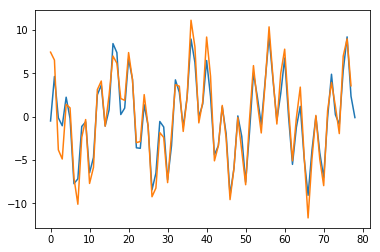

In [11]:
plt.plot(predictions.flatten())
plt.plot(test_batches_in[0][0][1:]);

### Text classificaiton example

In [ ]:
tf.reset_default_graph()
network = HMLSTMNetwork(output_size=29, input_size=29,
                        embed_size=1024, out_hidden_size=500,
                        hidden_state_sizes=200)

In [ ]:
batch_size = 2
truncate_len = 100
num_layers = 3
num_batches = 100

inputs = prepare_inputs(
    batch_size=batch_size, truncate_len=truncate_len, num_batches=num_batches)

In [ ]:
# test on last input\
network.train(inputs[0][:-1], inputs[1][:-1], load_existing_vars=True)

In [51]:
# predictions on last input
indicators = network.predict_boundaries(inputs[0][-1][0], reuse=True)
indicators

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [ ]:
# predictions on last input
predictions = network.predict(inputs[0][-1][0], reuse=True)

In [ ]:
def get_text(encoding):
    prediction = ''
    
    for char in np.squeeze(encoding):
        max_likelihood = np.where(char == np.max(char))[0][0]
        if max_likelihood < 26:
            prediction += ascii_lowercase[max_likelihood]
        elif max_likelihood == 26:
            prediction += ','
        elif max_likelihood == 27:
            prediction += '.'
        elif max_likelihood == 28:
            prediction += ' '
    
    return prediction

In [48]:
get_text(predictions)

'erl   nd ahes aoouene  ah te as eres eng   s ahrrl aetantanh ah tas  as   hhethaou  aooanthahh  oter'

In [49]:
get_text(inputs[0][-1][0][1:])

'ell. and this promises to be interesting. it would be a pity to miss it.   but your client     neve'